# Deep Learning Time Series Approach 
---


## **1.Data Wrangling**
---

### **1.1 Import Library**

In [85]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

### **1.2 Load Datasheet yang digunakan** 

In [86]:
df =pd.read_csv('../data/raw/Sunspots.csv')
print(df.head())

   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


In [87]:
print(df.tail())

      Unnamed: 0        Date  Monthly Mean Total Sunspot Number
3247        3247  2019-08-31                                0.5
3248        3248  2019-09-30                                1.1
3249        3249  2019-10-31                                0.4
3250        3250  2019-11-30                                0.5
3251        3251  2019-12-31                                1.6


In [88]:
df = df.drop(columns='Unnamed: 0',axis=1)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [89]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


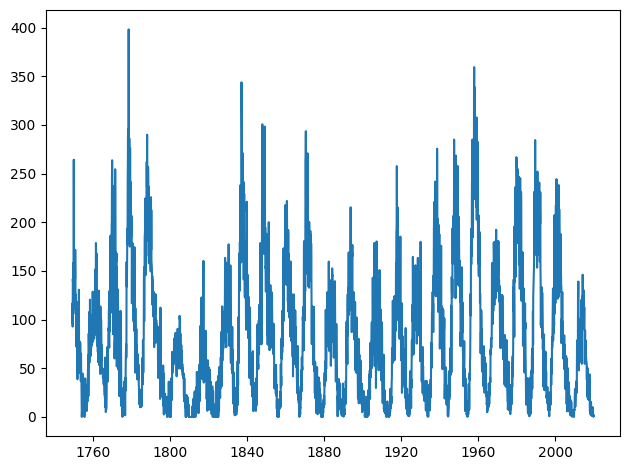

In [90]:
plt.plot(df['Monthly Mean Total Sunspot Number'])
plt.tight_layout()
plt.show()

In [91]:
def test_stationarity(timeseries):

    role_mean = timeseries.rolling(window=12).mean()
    role_std  = timeseries.rolling(window=12).std()

    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(role_mean, color='red', label='Rolling Mean')
    std  = plt.plot(role_std, color='black', label='Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

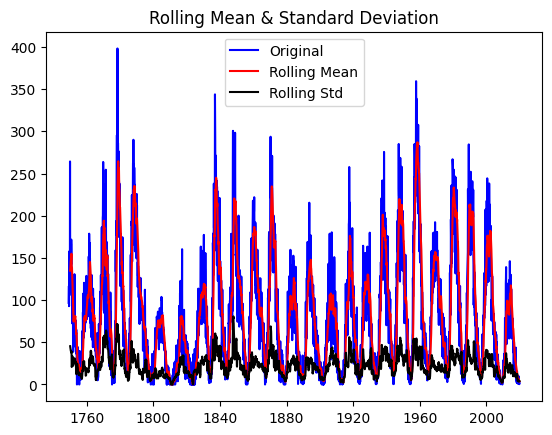

Results of Dickey-Fuller Test:
Test Statistic                -1.048087e+01
p-value                        1.214714e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.223000e+03
Critical Value (1%)           -3.432381e+00
Critical Value (5%)           -2.862437e+00
Critical Value (10%)          -2.567248e+00
dtype: float64


In [92]:
ts = df['Monthly Mean Total Sunspot Number']

test_stationarity(ts)

terlihat meansnya terus berubah sehingga tidak bisa disebut stasioner. menurut uji dickey-fuller, p-value = 0.99 > 0.05 sehingga HO gagal, data tidak stasioner, oleh karena itu kita perlu melakukan transformasi atau diffrencing 

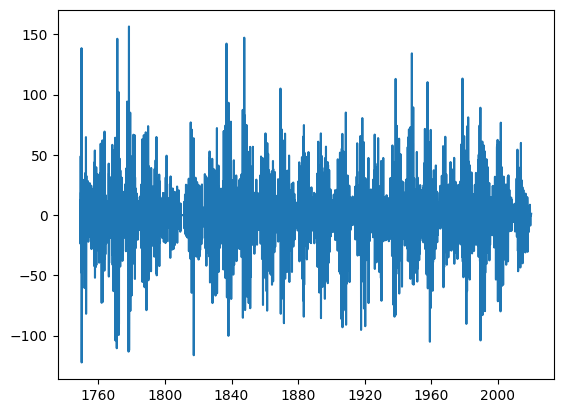

In [93]:
ts_diffrencing_1 = ts - ts.shift()
ts_diffrencing_1 = ts_diffrencing_1.dropna()
plt.plot(ts_diffrencing_1)

Terlihat masih belum stasioner, boleh coba diffrencing sekali lagi atau coba lanjutkan ke transformasi log

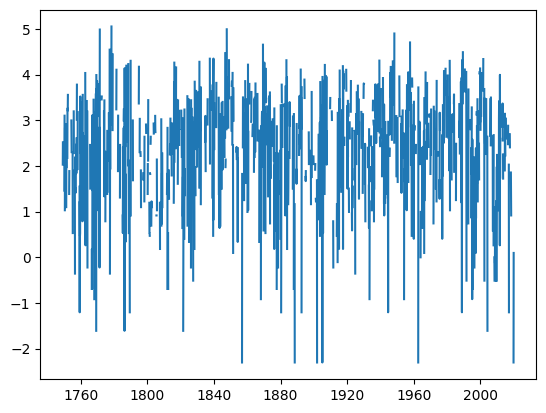

In [94]:
ts_diffrencing_log = np.log(ts_diffrencing_1)
plt.plot(ts_diffrencing_log)

Ternyata tidak lebih baik. Sekarang coba data awal yang ditransformasi log

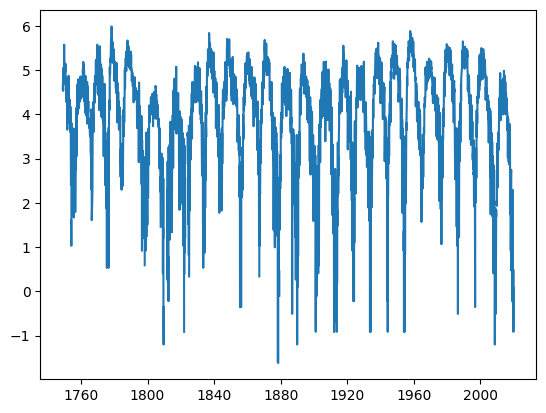

In [95]:
ts_log = np.log(ts)
plt.plot(ts_log)

Masih belum stasioner, tetapi secara varians terlihat lebih baik. Sekarang coba data yang ingin di diffrencing 

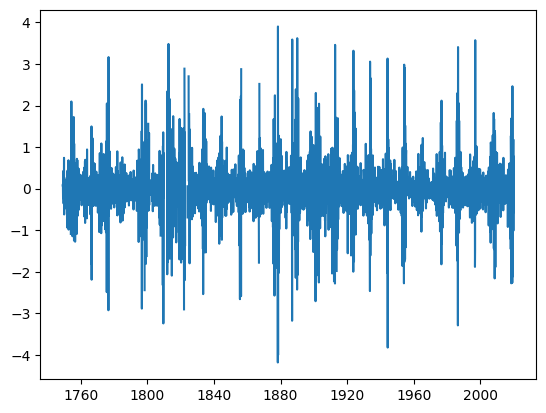

In [96]:
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

Sepertinya sudah stasioner, sekarang coba uji dickey-fuller supaya lebih meyakinkan

In [97]:
# test_stationarity(ts_log_1)

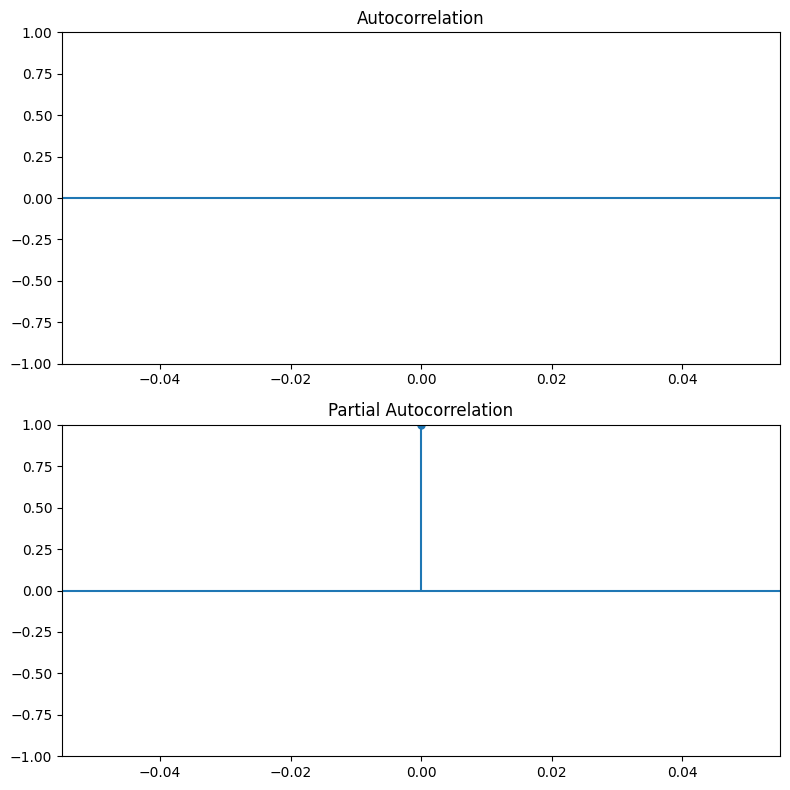

In [98]:
plt.figure(figsize=(8, 8))  # Atur ukuran figure agar lebih besar
plt.subplot(211)
plot_acf(ts_log_1, ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(ts_log_1, ax=plt.gca(), lags=12)

plt.tight_layout()
plt.show()

Terlihat bahwa keduanya cut off lag ke-1, lalu 4, lalu 8, ini menunjukkan pola seasonal (musiman) dengan orde 4. Sehingga kemungkinan modelnya

1. ARIMA(1, 1, 1) (p=1, d=1 karena sudah differencing sekali, q=1)
2. SARIMA(1, 1, 1)4, karena mencapai max/min tiap 4

Dan kombinasi lainnya dengan p=[1, 4, 8], d=1, q=[1, 4, 8]

### **Membuat model ARIMA**

In [101]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [102]:
p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3252
Model:                                ARIMA(1, 0, 2)   Log Likelihood              -15098.882
Date:                               Fri, 06 Dec 2024   AIC                          30207.764
Time:                                       08:53:33   BIC                          30238.199
Sample:                                   01-31-1749   HQIC                         30218.667
                                        - 12-31-2019                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.0685     15.623      5.253      0.000      51.449     112.688
ar.L1      

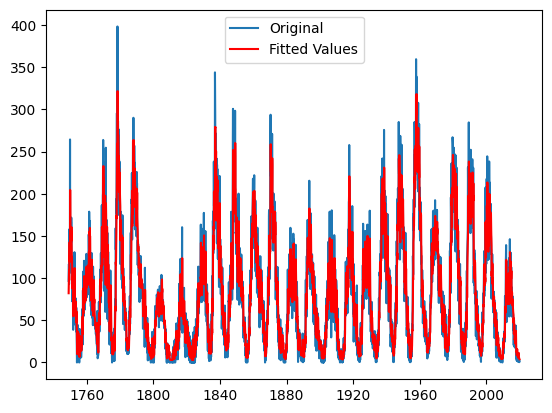

In [105]:
from statsmodels.tsa.arima.model import ARIMA

# Mendefinisikan model ARIMA
model_arima = ARIMA(ts, order=(1, 0, 2))
results_arima = model_arima.fit()  # Tidak perlu parameter disp

# Melihat hasil dan prediksi
print(results_arima.summary())

# Menampilkan fitted values
fitted_values = results_arima.fittedvalues

# Plot data asli dan fitted values
plt.plot(ts, label="Original")
plt.plot(fitted_values, label="Fitted Values", color="red")
plt.legend()
plt.show()


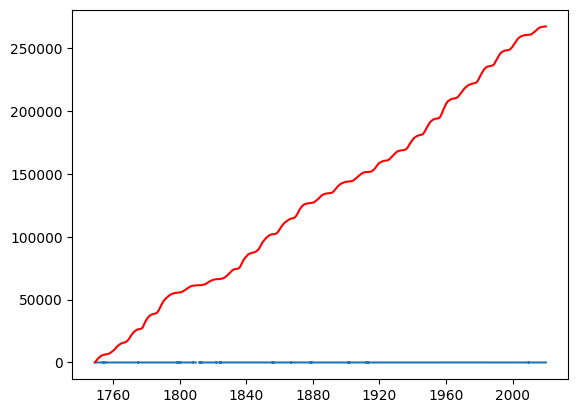

In [ ]:
predictions_arima_diff_cum_sum = fitted_values.cumsum()
predictions_arima_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_arima_log = predictions_arima_log.add(predictions_arima_diff_cum_sum, fill_value=0)
plt.plot(ts_log)
plt.plot(predictions_arima_log, color='red') # fitting dengan data yang ditransformasi

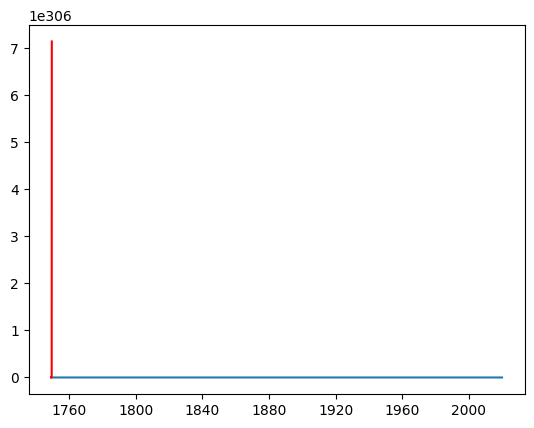

In [108]:
predictions_arima = np.exp(predictions_arima_log)
plt.plot(ts)
plt.plot(predictions_arima, color='red')

In [109]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3252
Model:                                ARIMA(1, 0, 2)   Log Likelihood              -15098.882
Date:                               Fri, 06 Dec 2024   AIC                          30207.764
Time:                                       09:06:48   BIC                          30238.199
Sample:                                   01-31-1749   HQIC                         30218.667
                                        - 12-31-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.0685     15.623      5.253      0.000      51.449     112.688
ar.L1          0.9827      0.004    278.042      0.000       0.976       0.990
ma.L1         -0.4063      0.014    -29.555      0.000      -0.433      -0.379
ma.L2         -0.1140      0.014     -8.348      0.000      -0.141      -0.087
sigma2       631.3471      9.964     63.362      0.000     611.818     650.876
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1776.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.64
Prob(H) (two-sided):                  0.43   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Kombinasi Model dengan Seasonal dan Trend**

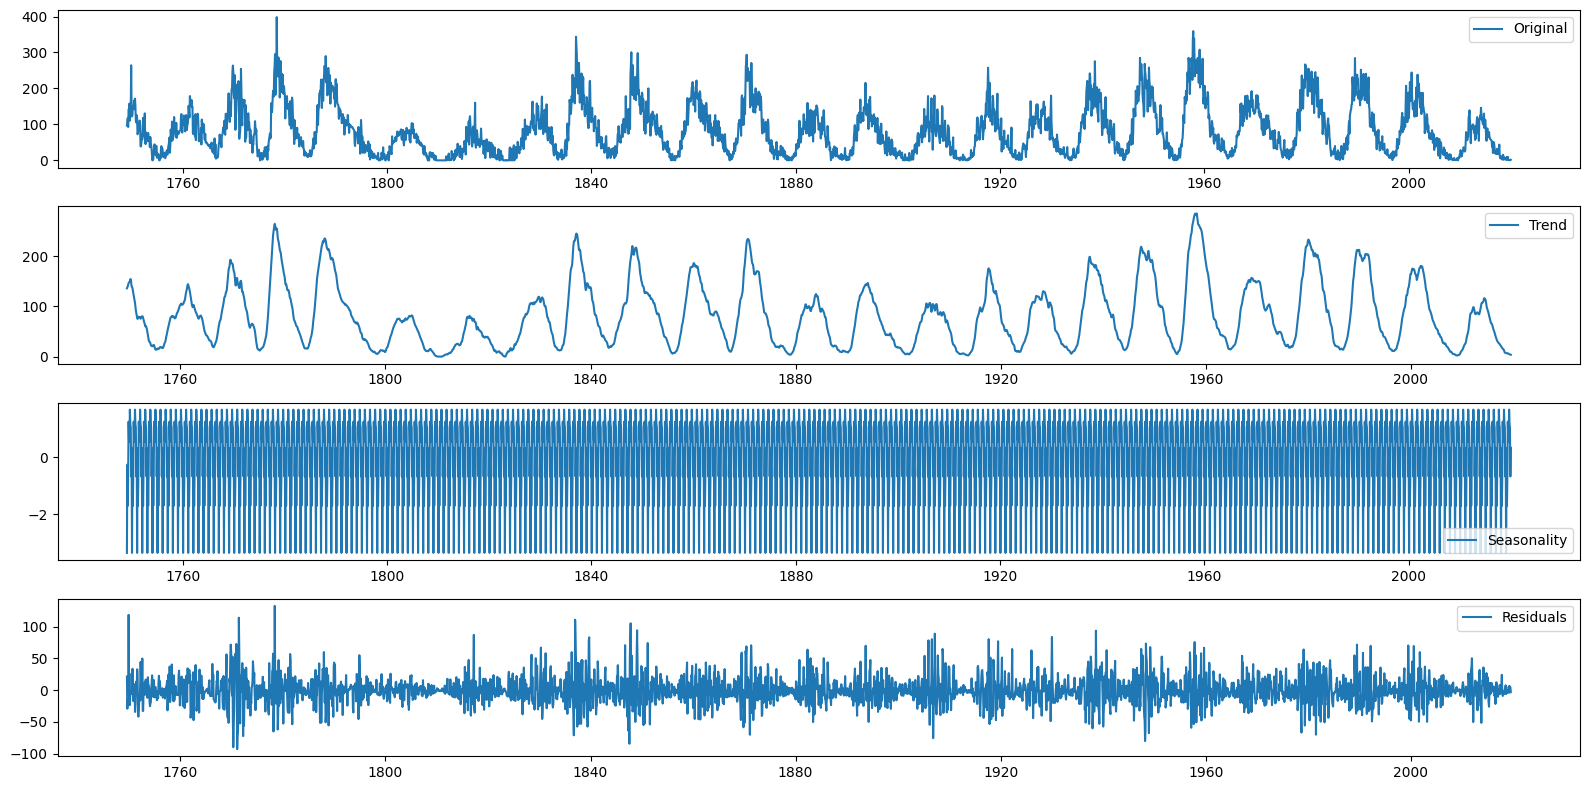

In [118]:
decomposition = seasonal_decompose(ts, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [120]:
# data training nya 70%
train_size = int(len(ts) * 0.7)
train, test = ts[:train_size], ts[train_size:]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,4))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

24.938476754178716


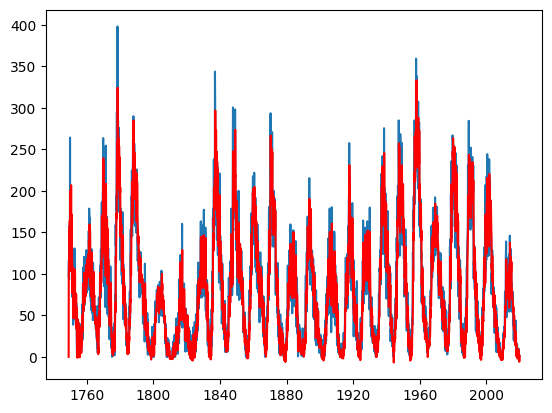

In [132]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='red')               #fitting dengan data

In [134]:
results_SARIMA_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3252
Model:                 SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood              -15470.380
Date:                               Fri, 06 Dec 2024   AIC                          30952.760
Time:                                       14:08:03   BIC                          30989.273
Sample:                                   01-31-1749   HQIC                         30965.841
                                        - 12-31-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -4.763e-06    8.5e-06     -0.560      0.575   -2.14e-05    1.19e-05
ar.L1          0.4121      0.047      8.824      0.000       0.321       0.504
ma.L1         -0.7822      0.032    -24.240      0.000      -0.845      -0.719
ar.S.L4        0.0510      0.032      1.580      0.114      -0.012       0.114
ma.S.L4       -0.9295      0.016    -56.509      0.000      -0.962      -0.897
sigma2      1309.6483     38.603     33.926      0.000    1233.988    1385.309
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):              1085.86
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.25
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=144,end=156)
print(pred_2)

1761-01-31    103.925629
1761-02-28    102.939045
1761-03-31    140.865558
1761-04-30    129.633828
1761-05-31    124.244326
1761-06-30    155.192796
1761-07-31    158.947175
1761-08-31    151.573700
1761-09-30    159.614965
1761-10-31    156.994539
1761-11-30    154.419713
1761-12-31    151.194314
1762-01-31    113.170600
Freq: ME, Name: predicted_mean, dtype: float64
